# Universidade Federal de Juiz de Fora

## Aluno: Matheus Muniz Damasco

## Professor: Jairo Francisco de Souza

## Matéria: Tópicos Especiais em Aplicações da Computação

## 1. Introdução:

Nosso objetivo essa semana explorar mais profundamente o uso de word embeddings. Temos atualmente muitos embeddings já treinados para diversas línguas e também ferramentas que permitem facilmente treinar embeddings, como o gensim que foi colocado como link na disciplina. Assim, para contextos genéricos, dificilmente você terá a necessidade de treinar embeddings. Porém, isso se torna relevante se você precisar usar embeddings em contextos muito específicos.

* **Tarefa 1:** sua tarefa é criar um código no colab para treinar o gensim com um corpo de textos específicos de uma área de aplicação. Datasets de textos temos vários. Pense numa aplicação, escolha um dataset interessante pra isso, use o gensim para treinar esses dados e faça sua avaliação intrínseca desse treinamento. Como fazer isso? Basta testar algumas relações entre palavras, assim como o tutorial do gensim (sobre simpsons) que colocamos na disciplina.
Compare os seus resultados com um modelo muito bem treinado (vide o word2vec online que colocamos no site da disciplina).

* **Tarefa 2:** um uso interessante de word embeddings é permitir uma melhor classificação de textos e a tarefa de análise de sentimentos pode ser encarada como uma tarefa de classificação. O TextBlob usa internamente um word embedding para isso e é muito simples usar o analisador de sentimentos dele, vide o link que deixamos na disciplina. Teste o analisador de sentimentos do TextBlob para um vetor de frases e analise o resultado.

* **Tarefa 3:** use o modelo padrão do Gensim (não o que você treinou) para procurar as 20 palavras mais próximas de hate, love, boring, exciting, funny e confusing. Para cada palavra gerada, use o TextBlob para pegar o sentimento de cada uma das palavras da lista. O TextBlob te dará dois valores ao analisar o sentimento: a polaridade (negativo/positivo) e a subjetividade da palavra (objetivo/subjetivo). Pode-se ver mais aqui: https://textblob.readthedocs.io/en/dev/quickstart.html
Então, o que você vai fazer? Vamos plotar um gráfico com a polaridade (eixo y) e subjetividade (eixo x) de cada palavra da lista de origem. Assim, você terá 6 gráficos, um para cada gráfico, onde cada gráfico terá 20 palavras (todas as semelhantes de acordo com o gensim). Você notará que o modelo de embedding consegue encontrar palavras razoavelmente próximas em polaridade (e talvez em subjetividade). Para plotar o gráfico, pode-se usar um scatterplot. Veja exemplos: https://jakevdp.github.io/PythonDataScienceHandbook/04.02-simple-scatter-plots.html

# Bibliotecas

In [ ]:
!pip install gensim
!pip install -q textblob

In [ ]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import re
from time import time
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
import multiprocessing
from collections import defaultdict
from textblob import TextBlob
from gensim.models import KeyedVectors
import gensim.downloader as api
import matplotlib.pyplot as plt

In [ ]:
# Baixar recursos necessários do NLTK
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Datasets Avaliados para o Trabalho:

* O primeiro dataset avaliado para uso neste trabalho foi o PMC Open Access, uma coleção de artigos científicos disponibilizados gratuitamente pela PubMed Central (PMC), uma base de dados de revistas científicas mantida pelo National Center for Biotechnology Information (NCBI), que faz parte dos National Institutes of Health (NIH) nos Estados Unidos. No entanto, como o dataset é muito extenso, ele pode não ser adequado para uso no Colab devido às limitações de memória e armazenamento. Para saber mais sobre o dataset, acesse o [link](https://huggingface.co/datasets/TomTBT/pmc_open_access_section).
Se desejarmos baixá-lo no Colab, o código a seguir pode ser utilizado:

`load_dataset("TomTBT/pmc_open_access_section", "non_commercial")`

* O segundo dataset avaliado, e o escolhido para este trabalho, foi o Mental Health Corpus, um dataset bem menor, disponível no Kaggle neste [link](https://www.kaggle.com/datasets/reihanenamdari/mental-health-corpus/data). O Mental Health Corpus é uma coleção de textos relacionados a pessoas com ansiedade, depressão e outros problemas de saúde mental. Ele consiste em duas colunas: uma contendo os comentários e outra com rótulos que indicam se os comentários são considerados tóxicos ou não. Este corpus pode ser utilizado para uma variedade de finalidades, como análise de sentimentos, detecção de linguagem tóxica e análise de linguagem relacionada à saúde mental. Além disso, os dados do corpus podem ser úteis para pesquisadores, profissionais de saúde mental e outros interessados em compreender a linguagem e os sentimentos em torno de questões de saúde mental.

In [ ]:
# Carregar o dataset
df = pd.read_csv('/content/mental_health.csv')

# Exibir as primeiras linhas do dataset
df.head(5)

,text,label
0,dear american teens question dutch person hear...,0
1,nothing look forward lifei dont many reasons k...,1
2,music recommendations im looking expand playli...,0
3,im done trying feel betterthe reason im still ...,1
4,worried year old girl subject domestic physic...,1


In [ ]:
# Vamos ver se tem algum valor nulo em nosso dataset
df.isnull().sum()

,0
text,0
label,0


In [ ]:
# Vamos ver como estão distribuidos nossos Labels (se os comentários são considerados tóxicos ou não)
df['label'].value_counts(normalize=True) * 100

,proportion
label,
0,50.537942
1,49.462058


In [ ]:
# Mais algumas informaçõe sobre nosso dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27977 entries, 0 to 27976
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    27977 non-null  object
 1   label   27977 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 437.3+ KB


# Pré-processamento de texto

In [ ]:
# 3. Pré-processamento de texto
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def cleaning_nltk(text):
    # Aplicar regex para remover caracteres especiais e maisculas caso ainda existam em nosso texto
    text = re.sub("[^A-Za-z']+", ' ', str(text)).lower()
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    if len(tokens) > 2:
        return ' '.join(tokens)

In [ ]:
# Limpar o corpus e remover valores nulos e duplicados
cleaned_corpus = [cleaning_nltk(text) for text in df['text']]
cleaned_corpus = [text for text in cleaned_corpus if text]
df_clean = pd.DataFrame({'clean': cleaned_corpus}).dropna().drop_duplicates()

# Tokenizar o corpus

In [ ]:
#Tokenizar nosso texto limpo
tokenized_corpus = [text.split() for text in df_clean['clean']]

# Contrução de Bigramas

In [ ]:
phrases = Phrases(tokenized_corpus, min_count=30, progress_per=1000)
bigram_model = Phraser(phrases)
bigram_corpus = [bigram_model[doc] for doc in tokenized_corpus]

In [ ]:
# Contagem de frequência de palavras
word_freq = defaultdict(int)
for sent in bigram_corpus:
    for word in sent:
        word_freq[word] += 1

# Quantidade de palavras únicas
print("Número de palavras únicas no corpus:", len(word_freq))

Número de palavras únicas no corpus: 67592


In [ ]:
# Ordenar e exibir as 10 palavras mais frequentes
most_common_words = sorted(word_freq, key=word_freq.get, reverse=True)[:10]
most_common_frequencies = [(word, word_freq[word]) for word in most_common_words]

print("As 10 palavras mais frequentes e suas contagens:", most_common_frequencies)

As 10 palavras mais frequentes e suas contagens: [('im', 30901), ('want', 17087), ('like', 15371), ('life', 14574), ('know', 14565), ('one', 13195), ('get', 13114), ('time', 11203), ('people', 11081), ('would', 10856)]


# Treinar o modelo Word2Vec

O Word2Vec é uma técnica de aprendizado de máquina desenvolvida pelo Google para representar palavras em vetores numéricos de alta dimensão, onde a proximidade entre palavras reflete suas similaridades semânticas. Ele usa redes neurais para aprender esses vetores, treinando modelos em grandes conjuntos de dados de texto. Existem dois principais métodos no Word2Vec: CBOW (Continuous Bag of Words), que prevê uma palavra com base no contexto ao redor, e Skip-gram, que prevê o contexto a partir de uma palavra central. Essa abordagem permite que palavras semanticamente próximas (como "rei" e "rainha") fiquem próximas no espaço vetorial, tornando o Word2Vec amplamente utilizado em tarefas de NLP, como análise semântica, recomendação de palavras e outras aplicações de processamento de texto.

In [ ]:
# Obtém o número de núcleos disponíveis para processamento paralelo
cores = multiprocessing.cpu_count()

# Inicializa o modelo Word2Vec com os parâmetros especificados
w2v_model = Word2Vec(
    sentences=bigram_corpus,  # Corpus de treinamento, onde cada sentença já contém bigramas
    vector_size=300,          # Tamanho dos vetores de palavras, aqui 300 dimensões
    window=2,                 # Tamanho da janela de contexto (2 palavras antes e depois da palavra-alvo)
    min_count=20,             # Desconsidera palavras que aparecem menos de 20 vezes no corpus
    sample=6e-5,              # Taxa de amostragem para palavras de alta frequência (para downsampling)
    alpha=0.03,               # Taxa de aprendizado inicial
    min_alpha=0.0007,         # Taxa de aprendizado mínima durante o treinamento
    negative=20,              # Número de palavras "negativas" (não relacionadas) para o treinamento negativo
    workers=cores-1           # Número de threads para processamento paralelo, usando todos menos um núcleo
)

In [ ]:
# Construir o vocabulário e treinar o modelo
t = time()
w2v_model.build_vocab(bigram_corpus, progress_per=1000)
w2v_model.train(bigram_corpus, total_examples=w2v_model.corpus_count, epochs=30)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 3.89 mins


# Avaliação Intrínseca do Modelo

In [ ]:
# Relações de palavras para avaliação intrínseca
print("Similaridade entre 'life' e outras palavras relacionadas:")
print(w2v_model.wv.most_similar(positive=["anxiety"], topn=10))

Similaridade entre 'life' e outras palavras relacionadas:
[('severe_anxiety', 0.5595669746398926), ('anxiety_depression', 0.5289238095283508), ('debilitating', 0.5135688185691833), ('social_anxiety', 0.509797990322113), ('clinical_depression', 0.4964993894100189), ('depression', 0.4909741282463074), ('mood_swing', 0.4838895797729492), ('depression_anxiety', 0.4766775071620941), ('nausea', 0.46963661909103394), ('psychosis', 0.452790230512619)]


In [ ]:
print("\nSimilaridade entre 'depression' e outras palavras relacionadas:")
print(w2v_model.wv.most_similar(positive=["depression"], topn=10))


Similaridade entre 'depression' e outras palavras relacionadas:
[('depression_anxiety', 0.568692147731781), ('anxiety_depression', 0.5395745635032654), ('depressive', 0.5059685707092285), ('severe_depression', 0.5054545998573303), ('depressive_episode', 0.5038452744483948), ('anorexia', 0.4979149103164673), ('relapse', 0.497241735458374), ('bipolar_disorder', 0.4965388774871826), ('clinical_depression', 0.49142587184906006), ('anxiety', 0.4909741282463074)]


# TextBlob

O TextBlob é uma biblioteca de processamento de linguagem natural (NLP) em Python que simplifica a análise de texto. Com uma interface intuitiva, ele oferece funcionalidades para análise de sentimentos, correção gramatical, tradução e outras tarefas de NLP. O TextBlob calcula sentimentos com base em polaridade (indicando se um texto é positivo ou negativo) e subjetividade (indicando se é objetivo ou opinativo), sendo útil para aplicações como análise de sentimentos em redes sociais, revisão de produtos e classificação de opiniões.

In [ ]:
# Lista de frases para análise de sentimentos
frases = [
    "I'm feeling great today!",
    "This is the worst day of my life.",
    "I'm not sure how to feel about this.",
    "The project was a complete success.",
    "I'm disappointed with the results.",
    "This place makes me very happy.",
    "I hate waiting in long lines.",
    "The food was amazing and delicious!",
    "I feel so sad and alone.",
    "I can't believe how lucky I am!"
]

# Função para análise de sentimentos com TextBlob
def analisar_sentimentos(frases):
    resultados = []
    for frase in frases:
        blob = TextBlob(frase)
        polaridade = blob.sentiment.polarity
        subjetividade = blob.sentiment.subjectivity
        resultados.append({
            "Frase": frase,
            "Polaridade": polaridade,
            "Subjetividade": subjetividade
        })
    return pd.DataFrame(resultados)

# Exibir os resultados
df_resultados = analisar_sentimentos(frases)
print(df_resultados)

                                  Frase  Polaridade  Subjetividade
0              I'm feeling great today!    1.000000       0.750000
1     This is the worst day of my life.   -1.000000       1.000000
2  I'm not sure how to feel about this.   -0.250000       0.888889
3   The project was a complete success.    0.200000       0.200000
4    I'm disappointed with the results.   -0.750000       0.750000
5       This place makes me very happy.    1.000000       1.000000
6         I hate waiting in long lines.   -0.425000       0.650000
7   The food was amazing and delicious!    0.800000       0.950000
8              I feel so sad and alone.   -0.500000       1.000000
9       I can't believe how lucky I am!    0.416667       0.833333


## Análise dos Resultados
### Polaridade:

Frases como "I'm feeling great today!" e "This place makes me very happy." receberam uma polaridade de 1.0, indicando sentimentos muito positivos.

Frases como "This is the worst day of my life." e "I'm disappointed with the results." têm polaridades negativas altas, -1.0 e -0.75, refletindo sentimentos negativos intensos.

A frase "I'm not sure how to feel about this." tem uma polaridade ligeiramente negativa de -0.25, capturando a incerteza e um leve tom negativo.

### Subjetividade:

Frases muito pessoais, como "This is the worst day of my life." e "I feel so sad and alone.", têm uma subjetividade de 1.0, sugerindo que são baseadas principalmente em emoções ou opiniões.

A frase "The project was a complete success." é a mais objetiva, com subjetividade de 0.2, refletindo uma declaração mais factual.

A frase "The food was amazing and delicious!" tem uma subjetividade de 0.95, o que é esperado, pois expressa uma opinião pessoal.

# Análise de Sentimentos e Relações Semânticas em Embeddings de Palavras
Abaixo iremos explorar como embeddings de palavras capturam sentimentos e nuances semânticas. Usando um modelo pré-treinado do Gensim, identificamos as 20 palavras mais próximas de seis palavras-alvo: hate, love, boring, exciting, funny e confusing. Em seguida, com o TextBlob vamos medir a polaridade (positiva/negativa) e a subjetividade (objetiva/subjetiva) de cada palavra semelhante para plotarmos esses valores em gráficos de dispersão. Esses gráficos mostram se as palavras próximas compartilham sentimentos similares, permitindo avaliar a capacidade do modelo em refletir sentimentos e significados.

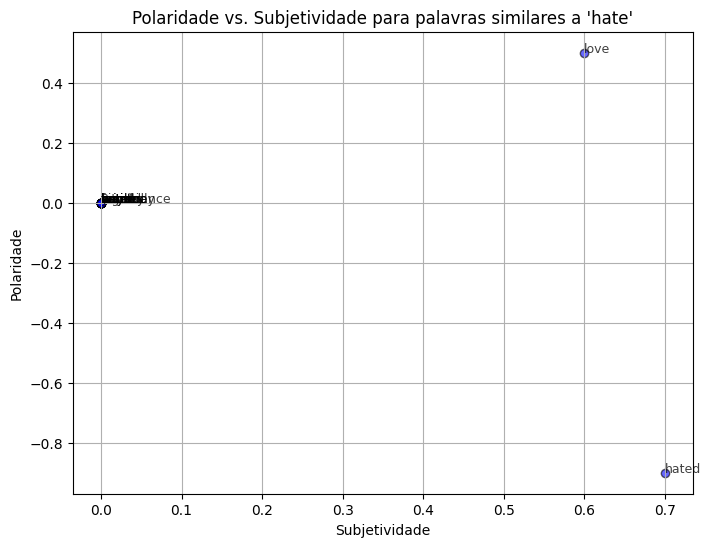

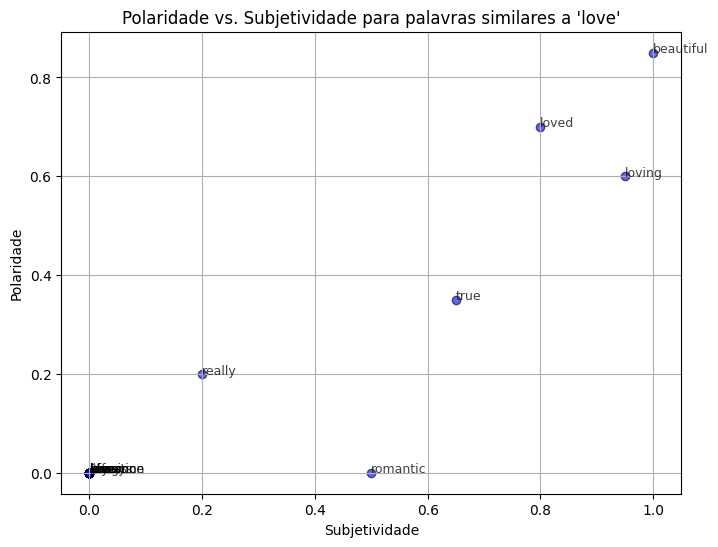

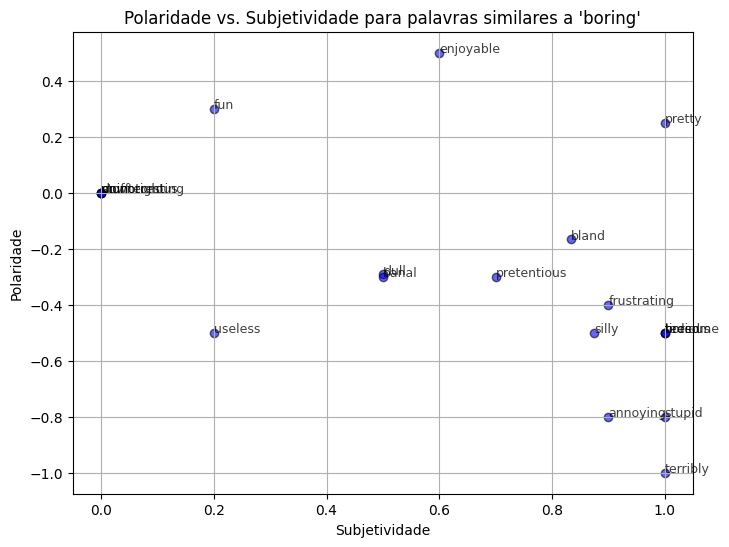

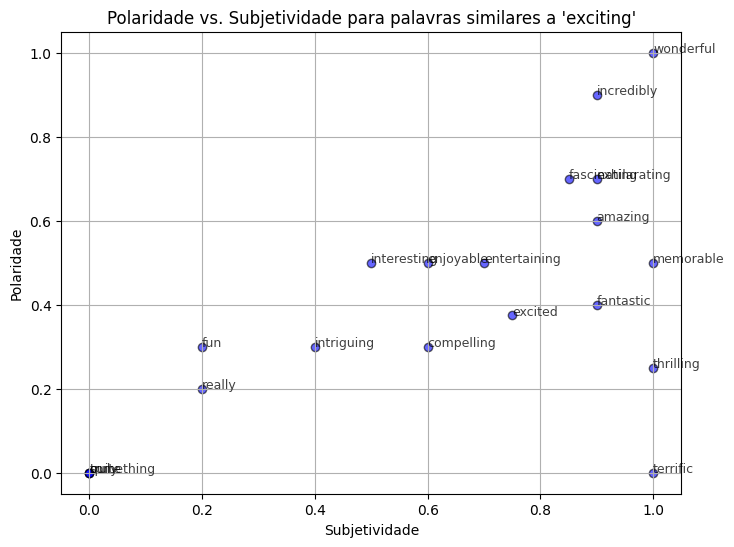

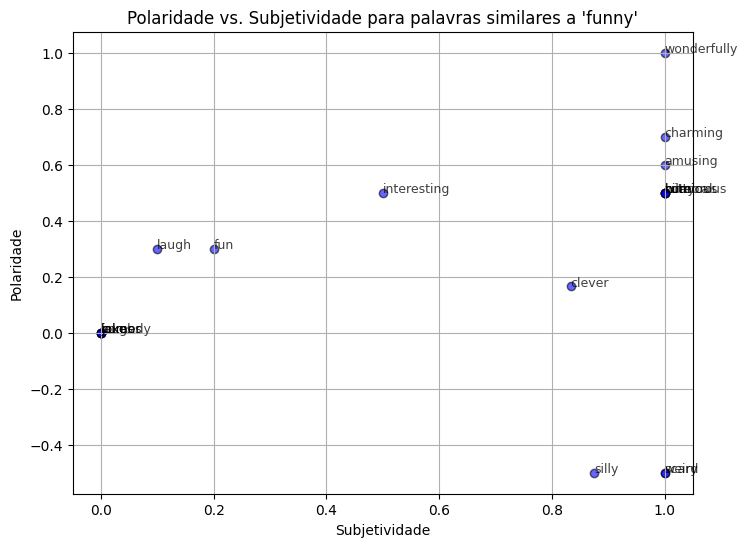

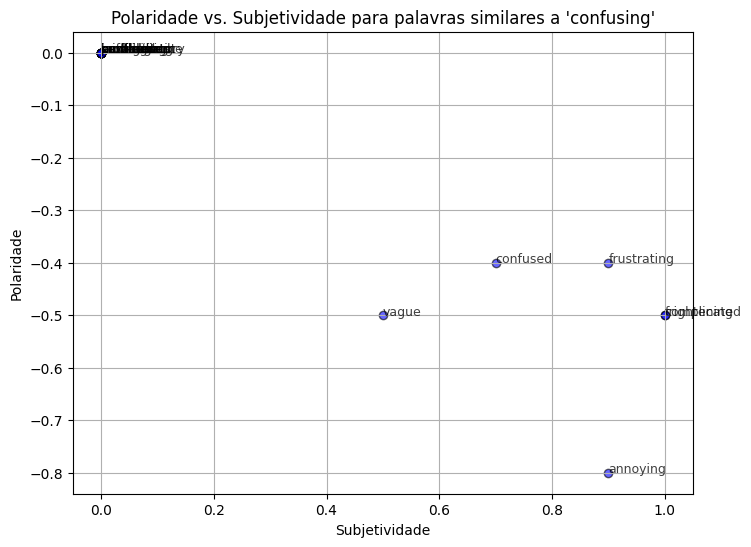

In [ ]:
# Carregar modelo de word embeddings pré-treinado
model = api.load("glove-wiki-gigaword-300")

# Palavras para encontrar as palavras mais próximas
target_words = ["hate", "love", "boring", "exciting", "funny", "confusing"]

# Função para obter as palavras mais próximas e calcular polaridade/subjetividade
def obter_polaridade_subjetividade(word):
    # Encontra as 20 palavras mais próximas
    try:
        similar_words = model.most_similar(word, topn=20)
    except KeyError:
        print(f"A palavra '{word}' não está no vocabulário do modelo.")
        return []

    # Analisar sentimentos com TextBlob
    sentiment_data = []
    for similar_word, _ in similar_words:
        blob = TextBlob(similar_word)
        polaridade = blob.sentiment.polarity
        subjetividade = blob.sentiment.subjectivity
        sentiment_data.append((similar_word, polaridade, subjetividade))

    return sentiment_data

# Gerar dados para cada palavra alvo
all_sentiment_data = {}
for word in target_words:
    all_sentiment_data[word] = obter_polaridade_subjetividade(word)

# Plotar gráficos
for word, sentiment_data in all_sentiment_data.items():
    # Extrair polaridade e subjetividade para o gráfico
    palavras, polaridades, subjetividades = zip(*sentiment_data)

    # Criar scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(subjetividades, polaridades, color="b", alpha=0.6, edgecolors="k")

    # Adicionar rótulos para cada ponto
    for i, palavra in enumerate(palavras):
        plt.annotate(palavra, (subjetividades[i], polaridades[i]), fontsize=9, alpha=0.75)

    plt.title(f"Polaridade vs. Subjetividade para palavras similares a '{word}'")
    plt.xlabel("Subjetividade")
    plt.ylabel("Polaridade")
    plt.grid(True)
    plt.show()

# Comparação entre Modelos
Agora vamos fazer uma comparação do nosso modelo treinado Word2Vec com o modelo 'glove-wiki-gigaword-300' que usamos acima, vamos também usar as palavras "depression", "confusing", "love" como base para comparação entre os dois modelos.

In [ ]:
# Palavras para comparar
palavras = ["depression", "anxiety", "love"]

# Comparação do nosso modelo Word2Vec com o modelo 'glove-wiki-gigaword-300'
# usando as palavras "depression", "anxiety", "love" como base
for palavra in palavras:
    print(f"\nSimilaridade de palavras com '{palavra}' no modelo treinado:")
    try:
        print(w2v_model.wv.most_similar(palavra, topn=10))
    except KeyError:
        print(f"'{palavra}' não está no vocabulário do modelo treinado.")

    print(f"\nSimilaridade de palavras com '{palavra}' no modelo GloVe:")
    try:
        print(model.most_similar(palavra, topn=10))
    except KeyError:
        print(f"'{palavra}' não está no vocabulário do modelo GloVe.")


Similaridade de palavras com 'depression' no modelo treinado:
[('depression_anxiety', 0.568692147731781), ('anxiety_depression', 0.5395745635032654), ('depressive', 0.5059685707092285), ('severe_depression', 0.5054545998573303), ('depressive_episode', 0.5038452744483948), ('anorexia', 0.4979149103164673), ('relapse', 0.497241735458374), ('bipolar_disorder', 0.4965388774871826), ('clinical_depression', 0.49142587184906006), ('anxiety', 0.4909741282463074)]

Similaridade de palavras com 'depression' no modelo GloVe:
[('anxiety', 0.5608508586883545), ('alcoholism', 0.5454232096672058), ('schizophrenia', 0.536712110042572), ('disorder', 0.5126984715461731), ('severe', 0.5126901268959045), ('postpartum', 0.49955350160598755), ('illness', 0.4802532196044922), ('bipolar', 0.4788492023944855), ('onset', 0.47345155477523804), ('suffering', 0.468968003988266)]

Similaridade de palavras com 'anxiety' no modelo treinado:
[('severe_anxiety', 0.5595669746398926), ('anxiety_depression', 0.5289238095